# Challenge 3 - understanding user and product interaction

Amazon’s employee travel provider has asked you to review how users interact with their online travel website.
They store their data in JSON files. Each row in these files lists all the different cities that have been searched for by a user within the same session (as well as some other info about the user). 

## Business Questions

1- There was a bug in the code and one country didn't get logged. Can you guess which country? How?<br>
2- For each city, find the most likely city to be also searched for within the same session.<br>
3- Travel sites are browsed by two kinds of users. Users who are actually planning a trip and users who just dream about a   vacation. The first group obviously has a much higher purchasing intent. Users planning a trip often search for cities close to each other, while users who search for cities far away from each other are often just dreaming about a vacation (or a great work trip!). Based on this idea, come up with an algorithm that clusters sessions into two groups: high intent and low intent.<br>

In the following notebooks, I will explore the available data and try to provide data-driven answers to the above business questions.

## Importing required libraries

In [1]:
import pandas as pd
import json
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import copy
import itertools
import warnings
warnings.filterwarnings("ignore")

## Read in and preprocessing the data

The data provided is in JSON format and include fields that can be summarised as below:

Fields:<br>
*session_id*: session id. <br> 
*unix_timestamp*: unix timestamp of session start time <br> 
*cities*: the unique cities which were searched within the same session <br> 
*user*: <br> 
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; *user_id*: the id of the user <br> 
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; *joining_date*: when the user created the account<br> 
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; *country*: where the user is based <br>
    
So, first I read in the data using the json loader from jason library.

In [2]:
dataPath = "./"
jsonStr = open(dataPath+'city_search.json').read()
jsonData = json.loads(jsonStr)
jsonData[0]

{'session_id': ['X061RFWB06K9V'],
 'unix_timestamp': [1442503708],
 'cities': ['New York NY, Newark NJ'],
 'user': [[{'user_id': 2024, 'joining_date': '2015-03-22', 'country': 'UK'}]]}

Inspecting the first element of the json hash confirms the given template above aabout the fields. I now want to convert this data to tabular format so I can analyse it more easily going forward. I use the utility provided in pandas library to convert json to dataframe. 

In [3]:
data = pd.io.json.json_normalize(jsonData)
data.head(10)

,session_id,unix_timestamp,cities,user
0,[X061RFWB06K9V],[1442503708],"[New York NY, Newark NJ]","[[{'user_id': 2024, 'joining_date': '2015-03-2..."
1,[5AZ2X2A9BHH5U],[1441353991],"[New York NY, Jersey City NJ, Philadelphia PA]","[[{'user_id': 2853, 'joining_date': '2015-03-2..."
2,[SHTB4IYAX4PX6],[1440843490],[San Antonio TX],"[[{'user_id': 10958, 'joining_date': '2015-03-..."
3,[JBRB8MZGTX3M4],[1427268063],[Edmonton AB],"[[{'user_id': 7693, 'joining_date': '2015-03-1..."
4,[YJCMPURC2FL9C],[1430559067],"[Phoenix AZ, Houston TX]","[[{'user_id': 7506, 'joining_date': '2015-02-2..."
5,[LKOKP80QD6BEO],[1434199991],[San Diego CA],"[[{'user_id': 3743, 'joining_date': '2015-03-0..."
6,[YOVUIM79SGS5Y],[1443171887],"[Montreal QC, Chicago IL]","[[{'user_id': 8831, 'joining_date': '2015-03-0..."
7,[SHXEY67QWKP9K],[1431766104],"[Calgary AB, New York NY]","[[{'user_id': 587, 'joining_date': '2015-03-16..."
8,[9P74JL5KMC9G9],[1434816246],"[Chicago IL, New York NY]","[[{'user_id': 365, 'joining_date': '2015-03-22..."
9,[UY49RTVRX3GL7],[1439104667],[New York NY],"[[{'user_id': 5995, 'joining_date': '2015-03-2..."


SO far so good... The json_normaliser read objects as is, in this case arrays. As such, I need to further process this data to bring it to a format ready for analysing. <br>
Column "session_id" is easy to process as I only need use the unique id (first element) as a scalar.<br> 
For "unix_timestamp", I decide to convert it (the first and only element of array) to date and time values, so I can work with them for analysis. I use the utility provided in datetime libaryr for this purpose. <br>
"Cities" column contains collection of cities within one search session. I just convert it to a string. <br>
The "user" column is most interesting: it contains three sub-fields. I want to bring all of them to the surface and add to the columns of the dataframe. So I replace the "user" column with "user_id", "joining_date" and "country". <br>Before that, I just want to make sure that all the subfields of "user" only have one single entry (i.e. could a user have multiple sets of info?). So first I check for that.     

In [4]:
#check if there are any multi-values in user info arrays
print("First layer array length = ", data['user'].map(lambda x: len(x)).max())
print("Second layer array length = ", data['user'].map(lambda x: len(x[0])).max())

First layer array length =  1
Second layer array length =  1


Cool... so there is not users with multiple information. Therefore, I can go ahead with the processing of the data as mentioned above. On important decision for me is that for any field that has not entry, I will replace it with a pandas NaN object so I can detec it later in my analysis. Finally, I also decided to sort the data based on session date and time. I think it will be easier for qucik inspections going forward.

In [5]:
data['session_id'] = data['session_id'].map(lambda x: x[0] if x[0]!="" else np.NaN)
data['session_date'] = data['unix_timestamp'].map(lambda x: datetime.utcfromtimestamp(x[0]).strftime('%Y-%m-%d') if x[0]!="" else np.NaN)
data['session_time'] = data['unix_timestamp'].map(lambda x: datetime.utcfromtimestamp(x[0]).strftime('%H:%M:%S') if x[0]!="" else np.NaN)
data['cities'] = data['cities'].map(lambda x: ''.join(x) if len(x)>0 else np.NaN)
for col in ['user_id', 'joining_date', 'country']:
    data[col] = data['user'].map(lambda x: x[0][0][col] if x[0][0][col]!="" else np.NaN)
data = data.drop(['user', 'unix_timestamp'], axis=1)
data.sort_values(['session_date', 'session_time'], inplace=True)
data.head(10)

,session_id,cities,session_date,session_time,user_id,joining_date,country
12866,I9A6XU2KX4QLY,Los Angeles CA,2015-02-28,03:40:35,7327,2015-02-28,NaN
3051,YAVR0T93L6Z6W,New York NY,2015-02-28,15:30:16,9713,2015-02-28,US
5999,DRAR5CK2PVT7J,New York NY,2015-03-01,03:33:58,5005,2015-02-28,IT
7401,2TO9HMQEK5D9M,"Los Angeles CA, Anaheim CA, Santa Ana CA, Long...",2015-03-01,11:36:11,1942,2015-03-01,ES
923,R3EW1FQVC7MQO,"New York NY, Jersey City NJ",2015-03-01,12:33:50,6419,2015-03-01,DE
2561,HCCFWYHWI2NHQ,Toronto ON,2015-03-01,12:45:51,286,2015-02-28,NaN
18805,CR7GXYLP4AZ1X,OTTAWA ON,2015-03-01,13:37:11,603,2015-02-28,US
8802,UC8MULBH0TJOP,Chicago IL,2015-03-01,18:05:37,5659,2015-02-28,IT
5425,BJSZQ8C1R85YL,"Toronto ON, Chicago IL",2015-03-02,00:27:29,9099,2015-03-01,US
7287,SANFHCC05LZRE,"Houston TX, San Antonio TX, Austin TX",2015-03-02,01:44:20,6066,2015-03-01,US


## Exploratory data analysis

Before proceeding to answer the business questions, I do some preliminary exploration of the data in hand. <br>

### *size and type of data*

In [6]:
print("size of the data is: ", data.shape,"\n")
data.info()

size of the data is:  (20022, 7) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20022 entries, 12866 to 5649
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   session_id    20022 non-null  object
 1   cities        20022 non-null  object
 2   session_date  20022 non-null  object
 3   session_time  20022 non-null  object
 4   user_id       20022 non-null  int64 
 5   joining_date  20022 non-null  object
 6   country       17202 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.2+ MB


### *check if all session ids are unique*

In [7]:
len(data['session_id'].unique())==data.shape[0]

True

No duplicate are found is session ids... Great!

### *how about users?*

In [8]:
print(f"{len(data['user_id'].unique())} unique users")
print(f"{len(data['country'].unique())} unique countries including 1 mystery country")

5777 unique users
7 unique countries including 1 mystery country


### *check for missing values*

In [9]:
data.isna().sum()

session_id         0
cities             0
session_date       0
session_time       0
user_id            0
joining_date       0
country         2820
dtype: int64

The field "country" has 2820 missing values. This is expected and related to question 1. So I'll leave it until then. No other missing values.. Great again!

### *just curious to know how the number of cities in one search spread across various sessions*

I want to know how large (in terms of number of cities being searched) a session can be? First I create the relevant column and then check unique value counts in this column.

In [10]:
data['num_cities'] = data['cities'].map(lambda x: len(x.split(",")) if ~pd.isna(x) else np.NaN)
data['num_cities'].value_counts()

1     10671
2      6906
3      1619
4       566
5       178
6        61
7        16
8         3
11        1
9         1
Name: num_cities, dtype: int64

### *check the span of session_dates*

In [11]:
print(f"there are {len(data['session_date'].unique())} session dates from {data['session_date'].min()} to {data['session_date'].max()}")
#check if the days are continous, i.e. there is no gap in the period
len(data['session_date'].unique()) == (datetime.strptime(data['session_date'].max(), '%Y-%m-%d') - datetime.strptime(data['session_date'].min(), '%Y-%m-%d')).days+1

there are 217 session dates from 2015-02-28 to 2015-10-02


True

So there are 217 consecutive days with no days missing in the middle.

# Q1

#### 1- There was a bug in the code and one country didn't get logged. Can you guess which country? How?<br>

First lets check how much of the data is missing:

In [12]:
print("%5.2f percent of the data has missing countries"%(data['country'].isna().sum()*100/len(data['country'])))

14.08 percent of the data has missing countries


More than 14% is is a considerable amount. I can think of a couple of potential ways to find out (or make a strong guess) of what the missing country could be?

### First attempt/logic:

I first check the "user_id" of the missing countries against non-missing countries to see if the same user_id might have been assinged to another country in another session.

In [13]:
list(set(data[data['country'].isna()]['user_id'].unique()) & set(data[~data['country'].isna()]['user_id'].unique()))

[]

Unlucky... There were no intersection between the users with missing country values and the ones with country values.

### Second attempt/logic:

Another way I can think of is to try to guess the missing country based on the hour of the session. I would guess depending on the time zone, there are certain times that are more likely for people to searh this travel website. Let's explore from that angle. 

I will first create required attribute (column) to be able to analyse the data.

In [14]:
data['session_hour'] = data['session_time'].map(lambda x: int(str(x).split(":")[0]))
data['country'].fillna('unknown', inplace=True) 
data.head()

,session_id,cities,session_date,session_time,user_id,joining_date,country,num_cities,session_hour
12866,I9A6XU2KX4QLY,Los Angeles CA,2015-02-28,03:40:35,7327,2015-02-28,unknown,1,3
3051,YAVR0T93L6Z6W,New York NY,2015-02-28,15:30:16,9713,2015-02-28,US,1,15
5999,DRAR5CK2PVT7J,New York NY,2015-03-01,03:33:58,5005,2015-02-28,IT,1,3
7401,2TO9HMQEK5D9M,"Los Angeles CA, Anaheim CA, Santa Ana CA, Long...",2015-03-01,11:36:11,1942,2015-03-01,ES,4,11
923,R3EW1FQVC7MQO,"New York NY, Jersey City NJ",2015-03-01,12:33:50,6419,2015-03-01,DE,2,12


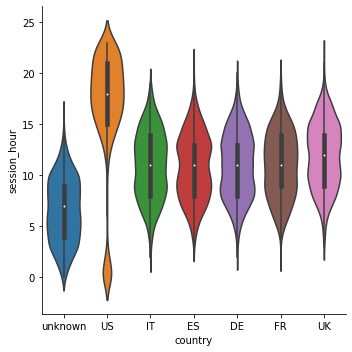

In [15]:
sns.catplot(x='country', y='session_hour', data=data, kind='violin')

In [16]:
data.groupby('country')['session_hour'].median()

country
DE         11
ES         11
FR         11
IT         11
UK         12
US         18
unknown     7
Name: session_hour, dtype: int64

Nice results. There is no time difference between countries Denmark, Spain, France and Italy; they are all on +2UTC. The results above are consistent with this and my hypothesis kind of seems promising as certain times of the day are mosre likely for people from the same time zone to search the travel website. Plus, because the times I have created above in "session_time" are based on UTC time zone, so I can see that most popular time for sessions from these three countries are 1 pm local time (which is reasonable as this could be people searching the website in their lunch time break!). <br>

Super interesting that 1 PM local time is consistent with what we see for UK as well, as UK is +1UTC. <br>
What about US? It is more complicated for US as it has multiple time zones accross the country, from -4 to -10 UTC. From our data, the most likely UTC time for US is 18 (or 6pm). So for example, if I consider CDT, I will again get 1pm local (CDT) time.

I also notice that looking at the span of session dates (in EDA section), the period is from very late Feb to very early oct, all in northern hemisphere. As such, I believe the effect of daylight savings are going to be minimal (if any), because I used the median of the times to make a decision, so I don't need to be careful about that.

## Q1 answer:

As such, I would bet my money on the best guess of 1pm local time. So giving a half an hour of error room either side, I can narrow down the search for the missing country to +5:30UTC to +6:30UTC time zones. Some countries in central Asia (Kazakhstan, Kyrgyzstan etc) or Indian penensiula (India, Bangladesh etc) are strong candidates for this. Given these sessions are for Amazon employees, I believe giving this narrow down to the travel provider can help them identify the exact country at once. 

# Q2

#### 2- For each city, find the most likely city to be also searched for within the same session.

### Solution logic:

The logic I have to answer this question is to evaluate conditional probabilities. I define p(c2|c1) or probability of c1 given c1 as: given we know city c1 is search in a session, what is the probability of city c2 being searched in the same session? Then, for each city, I can choose the city with highest conditional probability as the answer to question 2. 

To go about this, I first obtain the list of all unique cities whose names are appeared in our dataset (in the all sessions).

In [17]:
uniqueCities = []
[uniqueCities.extend([c.strip() for c in x.split(',')]) for x in data['cities'].unique()]
uniqueCities = list(set(uniqueCities))
#uniqueCities

Next, I create some helper functions to do the calculations I need. I know p(c2 given c1) = p(c2 AND c1) devided by p(c1). Because here the denominator to calculate both probabilities on the right hand side are the same (number of all sessions), then the right hand side can be simplified as:  p(c2 given c1) = number of sessions with both c2 AND c1 devided by number of session with c1. That is exactly how the below functions are written. 

In [18]:
def countRowsWithCities(x, y):
    return data['cities'].map(lambda c: (x in c) and (y in c)).sum()

def countRowsWithCity(x):
    return data['cities'].map(lambda c: (x in c)).sum()

def condProb(y, x):
    if x == y: return 0.0
    return float(countRowsWithCities(x, y)/countRowsWithCity(x))

Now, I do this calculation all in a new dataframe. I first generate all possible double combinations of the unique cities apearing in our dataset (using itertools library). Then, to be easier to read the results, I create separate columns with first (c1) and second (c2) city in the combo and finally create a column with calculation of probability c2 given c1, using the functions defined above.   

At last, I find the highest conditional probability for each city (c1) by grouping and aggregating (max) the data. At the end, I have the answer for question 2: For each city in column "c1", the most probable city to apear in the same session is given in the same row in column "c2" with the probability given in columns "prob_c2_given_c1". 

In [19]:
associationDf = pd.DataFrame({'city_combos': itertools.combinations(uniqueCities, 2)})
associationDf['c1'] = associationDf['city_combos'].map(lambda r: r[0])
associationDf['c2'] = associationDf['city_combos'].map(lambda r: r[1])
associationDf['prob_c2_given_c1'] = associationDf.apply(lambda r: condProb(r['c2'], r['c1']), axis=1)
associationDf.head()

,city_combos,c1,c2,prob_c2_given_c1
0,"(Cleveland OH, Dallas TX)",Cleveland OH,Dallas TX,0.00
1,"(Cleveland OH, Philadelphia PA)",Cleveland OH,Philadelphia PA,0.00
2,"(Cleveland OH, Oshawa ON)",Cleveland OH,Oshawa ON,0.02
3,"(Cleveland OH, Vancouver BC)",Cleveland OH,Vancouver BC,0.00
4,"(Cleveland OH, Scottsdale AZ)",Cleveland OH,Scottsdale AZ,0.00


I also write out the results in a csv file named "ch3_q2_answer.csv"

In [20]:
res = associationDf.groupby('c1').max().reset_index().drop(['city_combos'], axis=1)
res.to_csv("q2_answer.csv", index=False)
res

,c1,c2,prob_c2_given_c1
0,Anaheim CA,Windsor ON,0.748120
1,Arlington TX,Windsor ON,0.380531
2,Atlanta GA,Windsor ON,0.952381
3,Austin TX,Windsor ON,0.663866
4,Bakersfield CA,Windsor ON,0.282051
...,...,...,...
83,Victoria BC,Windsor ON,0.411168
84,Virginia Beach VA,Windsor ON,0.882353
85,WASHINGTON DC,Windsor ON,0.783133
86,Wichita KS,Windsor ON,1.000000


# Q3

#### 3- Travel sites are browsed by two kinds of users. Users who are actually planning a trip and users who just dream about a   vacation. The first group obviously has a much higher purchasing intent. Users planning a trip often search for cities close to each other, while users who search for cities far away from each other are often just dreaming about a vacation (or a great work trip!). Based on this idea, come up with an algorithm that clusters sessions into two groups: high intent and low intent.

### Solution logic:

The algorithm I would suggest for this question is to first calculate the average distance between the cities searched in one sessions. For that, I will first get coordinates for each city name using the geocoder provided by Nominatim through geopy. Because the logic for clustering here is based on the distance between the cities that are search in one session, I will use the distance calculation provided by geopy libary as well (using geodesic calculation) to calculate distances between each two set of coordinates (i.e. between each pari of cities). For collection of cities in each session, I then calculate the average and standard deviation of distances to get a better idea of the type of search the user had during that session. Finally, I need to decide how to define "far" vs "close", as described in the business question. While there are other ways to do so, I use kmeans clustering to cluster the data based on these two attributes to cluster the data.

First, as the connection to Nominatim can be flaky sometimes, I create a dataframe including unique cities in our dataset and corresponding coordinate. I write it to csv in case I need to reuse it and conection is problematic. Finally, it is easier to use a dictinary for mapping, hence I create a dictinary with keys as city names and values as coordinate pair (lat, long). 

In [21]:
from geopy.geocoders import Nominatim
geolocator = Nominatim()  #use the Nominatim API
coordsDf = pd.DataFrame()

#first time to run on new cities, run this code, otherwise can read from the csv file:

#coordsDf['city'] = uniqueCities 

#use geolocator to get lat and long for each city name
#coordsDf['coordinate'] = coordsDf['city'].map(lambda c: (geolocator.geocode(c).latitude, geolocator.geocode(c).longitude))

#coordsDf.to_csv("../data/city_coordinates.csv", index=False) #write to csv just in case

In [22]:
coordsDf = pd.read_csv("city_coordinates.csv")
coordinateMap = dict(zip(coordsDf['city'], coordsDf['coordinate']))  #create dictionary map

next are some helper functions:

In [23]:
import itertools
import geopy.distance

def getCoordinatesForCities(st):   #gets the cities string delimited by "," and returns list of coordinates, one for each city
    cities = [x.strip() for x in st.split(',')] #get list of city names
    return [coordinateMap[city] for city in cities] #get list of coordinates using the map created above

def getDistances(coords): #gets list of coordinates and returns distance between each two coordinate pairs
    distances = []
    for coordCombo in itertools.combinations(coords, 2): #for each pair of coordinate pairs (cities)
        distances.append(geopy.distance.geodesic(coordCombo[0], coordCombo[1]).km) #calculate the distance between two coordinates
    return distances

Now using the helper function above, I create the coordinates column, one coordinate pair for each city name.

In [24]:
data['coordinates'] = data['cities'].map(getCoordinatesForCities)  #create coordinates column
data.head() 

,session_id,cities,session_date,session_time,user_id,joining_date,country,num_cities,session_hour,coordinates
12866,I9A6XU2KX4QLY,Los Angeles CA,2015-02-28,03:40:35,7327,2015-02-28,unknown,1,3,"[34.0536909, -118.2427666]"
3051,YAVR0T93L6Z6W,New York NY,2015-02-28,15:30:16,9713,2015-02-28,US,1,15,"[40.7127281, -74.0060152]"
5999,DRAR5CK2PVT7J,New York NY,2015-03-01,03:33:58,5005,2015-02-28,IT,1,3,"[40.7127281, -74.0060152]"
7401,2TO9HMQEK5D9M,"Los Angeles CA, Anaheim CA, Santa Ana CA, Long...",2015-03-01,11:36:11,1942,2015-03-01,ES,4,11,"[34.0536909, -118.2427666, 33.8347516, -117.91..."
923,R3EW1FQVC7MQO,"New York NY, Jersey City NJ",2015-03-01,12:33:50,6419,2015-03-01,DE,2,12,"[40.7127281, -74.0060152, 40.7281575, -74.0776..."


Using the "coordinates" column, now I calculate the list of distances in the "distances" column. 

After that, using this newly created column, I calculate the average and standard deviation of distances in separate columns. I use standard deviation to be able to better compare the variance of distances accross various sessions. Note here that I will put 0.0 (for both mean and std) when there is only one city search, hence the list of distances is empty. 

In [25]:
data['distances'] = data['coordinates'].map(getDistances)   #create list of distances for each session in a separate column
data['avg_distance'] = data['distances'].map(lambda x: np.mean(x) if len(x)>0 else 0.0)  #get average of distances
data['std_distance'] = data['distances'].map(lambda x: np.std(x) if len(x)>0 else 0.0)  #get std of distances
data.head()

,session_id,cities,session_date,session_time,user_id,joining_date,country,num_cities,session_hour,coordinates,distances,avg_distance,std_distance
12866,I9A6XU2KX4QLY,Los Angeles CA,2015-02-28,03:40:35,7327,2015-02-28,unknown,1,3,"[34.0536909, -118.2427666]",[],0.000000,0.00000
3051,YAVR0T93L6Z6W,New York NY,2015-02-28,15:30:16,9713,2015-02-28,US,1,15,"[40.7127281, -74.0060152]",[],0.000000,0.00000
5999,DRAR5CK2PVT7J,New York NY,2015-03-01,03:33:58,5005,2015-02-28,IT,1,3,"[40.7127281, -74.0060152]",[],0.000000,0.00000
7401,2TO9HMQEK5D9M,"Los Angeles CA, Anaheim CA, Santa Ana CA, Long...",2015-03-01,11:36:11,1942,2015-03-01,ES,4,11,"[34.0536909, -118.2427666, 33.8347516, -117.91...","[39.06757347312749, 48.02850621465514, 5466.04...",2746.408574,2714.03335
923,R3EW1FQVC7MQO,"New York NY, Jersey City NJ",2015-03-01,12:33:50,6419,2015-03-01,DE,2,12,"[40.7127281, -74.0060152, 40.7281575, -74.0776...",[6.2895817337946],6.289582,0.00000


Did I get any missing values? Looks like the naswer is no.

In [26]:
data.isna().sum()

session_id      0
cities          0
session_date    0
session_time    0
user_id         0
joining_date    0
country         0
num_cities      0
session_hour    0
coordinates     0
distances       0
avg_distance    0
std_distance    0
dtype: int64

For the case of average = 0.0 (which force std = 0.0 as well), which means only one city is searched, I will label that as "high intent" based on the given logic by the business. 

Let's have a look at the distribution of non-zero mean and std values. 

In [27]:
data[data['avg_distance']>0][['avg_distance', 'std_distance']].describe()

,avg_distance,std_distance
count,9351.000000,9351.000000
mean,1239.242748,106.641800
std,1412.597144,389.604294
min,1.855839,0.000000
25%,159.873901,0.000000
50%,532.504649,0.000000
75%,2283.473189,3.430049
max,5475.882539,2714.033350


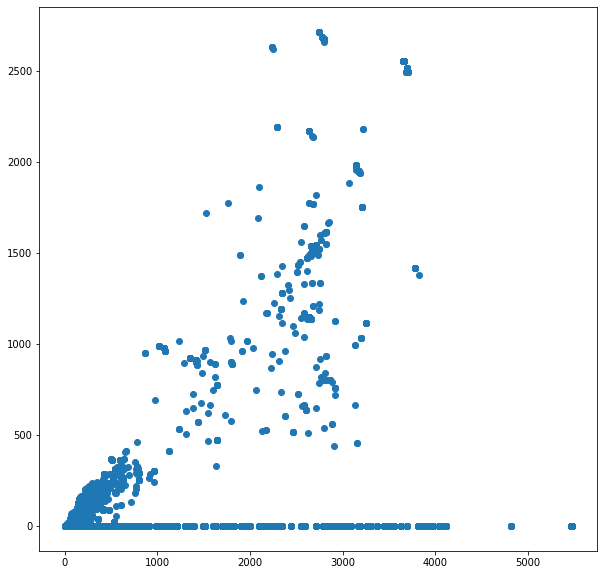

In [28]:
plt.figure(figsize=(10,10))
plt.scatter(data[data['avg_distance']>0]['avg_distance'], data[data['avg_distance']>0]['std_distance'])

The question to answer now is what is "far away" and "close" as mentioned in the business question? How to define them? These qualitative measures need to be translated into quantitative metrics. One way to do so is to get the business to specify some tolerances on mean and/or standard deviation attributes. A yet more efficient way is to analyse the history data including whether or not a session resulted in a booking/purchase, and analyse the relation between these attributes and likelihood of booking. In the absence of this data, and with not much of business context, I decide to choose the criteria based on the data in hand. A technique that can help me is kmean clustering. Kmeans will automatically cluster the data in a way to minimise the within-cluster variances (gives a good separation of data given the attributes). This way, I don't need to explicitly specify tolerances.  

Now I use kmean clustering from sklearn library to cluster my datapoints based on mean and std values into two clusters. 

A few notes on use of kmeans:

1- as clustering is sensetive to magnitude of datapoints, I first scale all values to interval [0, 1] using MinMaxScaler from sklearn. 

2- For kmean, I use k-mean++ for initialisation, which give a more robust initialisation that guarantees to find a solution that is O(log k) competitive to the optimal k-means solution. 

Text(0, 0.5, 'Std. distances')

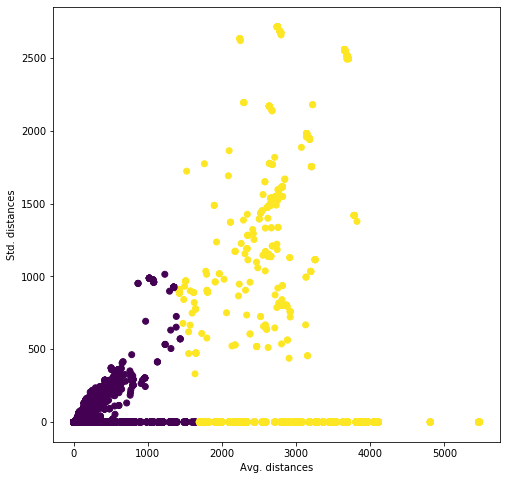

In [29]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

x = data[['avg_distance', 'std_distance']].values  #getting the datapoints (only mean and std values)
sc = MinMaxScaler()
x_sc = sc.fit_transform(x)     #min max scaling of data values

#fitting a kmeans object with 2 clusters and kmean++ initialisation
y_pred = KMeans(n_clusters=2, init='k-means++', random_state=0).fit_predict(x_sc)  

#plotting the results
plt.figure(figsize=(8,8))
plt.scatter(x[:, 0], x[:, 1], c=y_pred)
plt.xlabel("Avg. distances")
plt.ylabel("Std. distances")

Now I add the labels created by kmeans to the dataset in a new column called "intent" and will then write out the results in a csv file named "ch3_q3_answer.csv". 

In [30]:
data['intent'] = np.vectorize(lambda x: "high" if x==0 else "low")(y_pred)
data.head()

,session_id,cities,session_date,session_time,user_id,joining_date,country,num_cities,session_hour,coordinates,distances,avg_distance,std_distance,intent
12866,I9A6XU2KX4QLY,Los Angeles CA,2015-02-28,03:40:35,7327,2015-02-28,unknown,1,3,"[34.0536909, -118.2427666]",[],0.000000,0.00000,high
3051,YAVR0T93L6Z6W,New York NY,2015-02-28,15:30:16,9713,2015-02-28,US,1,15,"[40.7127281, -74.0060152]",[],0.000000,0.00000,high
5999,DRAR5CK2PVT7J,New York NY,2015-03-01,03:33:58,5005,2015-02-28,IT,1,3,"[40.7127281, -74.0060152]",[],0.000000,0.00000,high
7401,2TO9HMQEK5D9M,"Los Angeles CA, Anaheim CA, Santa Ana CA, Long...",2015-03-01,11:36:11,1942,2015-03-01,ES,4,11,"[34.0536909, -118.2427666, 33.8347516, -117.91...","[39.06757347312749, 48.02850621465514, 5466.04...",2746.408574,2714.03335,low
923,R3EW1FQVC7MQO,"New York NY, Jersey City NJ",2015-03-01,12:33:50,6419,2015-03-01,DE,2,12,"[40.7127281, -74.0060152, 40.7281575, -74.0776...",[6.2895817337946],6.289582,0.00000,high


In [31]:
data.to_csv('q3_answer.csv', index=False)